# Neural Network to recognize Simpsons characters

In [1]:
#Imports
import pandas as pd
from pathlib import Path
import os.path
from os.path import isfile, join
from os import listdir
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.preprocessing import image
import matplotlib.image as mpimg
import numpy as np
import shutil
import random
from distutils.dir_util import copy_tree
import warnings
from PIL import Image
import os, sys

warnings.filterwarnings('ignore')

In [ ]:
# I will use the Simpsons dataset from kaggle https://www.kaggle.com/alexattia/the-simpsons-characters-dataset
# The concept is that I downloaded the dataset into the folder that this notebook is executing and then from this original folder,I create with code train,validation and test directories with respective files inside it.I decided to train the 75% of images in each folder in the dataset and keep the 25% of images in each folder as a validation set, to keep it unbiased and use about 1600 images available for test.

In [2]:
#Function to list all files in directory and sub directories
def list_files(dir):                                                                                                  
    r = []                                                                                                            
    subdirs = [x[0] for x in os.walk(dir)]                                                                            
    for subdir in subdirs:                                                                                            
        files = os.walk(subdir).__next__()[2]                                                                             
        if (len(files) > 0):                                                                                          
            for file in files:                                                                                        
                r.append(os.path.join(subdir, file))                                                                         
    return r    

In [3]:
# The path to the directory where the original dataset was placed
original_dataset_dir = './dataset/simpsons_dataset/'

# Our working directory
base_dir = './dataset/simpsons/'
if (not os.path.exists(base_dir) ):
    os.mkdir(base_dir)

In [4]:
#Setup train,validation and test directories
train_dir = os.path.join(base_dir, 'train/')
if (not os.path.exists(train_dir) ):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation/')
if (not os.path.exists(validation_dir) ):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test/')
if (not os.path.exists(test_dir) ):
    os.mkdir(test_dir)


In [5]:
# Directories for our training, validation and test splits.Copy images inside them

train_dir = os.path.join(base_dir, 'train/')
if (not os.path.exists(train_dir) ):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation/')
if (not os.path.exists(validation_dir) ):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test/')
if (not os.path.exists(test_dir) ):
    os.mkdir(test_dir)

# Get image names(path) to array
simpsons_files = list_files(original_dataset_dir)

#Shuffle array
random.shuffle(simpsons_files)

#Collection to store copied files, so as each folder to have different ones
file_list = []

#Copy 75% of the images of each folder for train

counter=0
subdirs = [x[0] for x in os.walk(original_dataset_dir)]                                                                            
for subdir in subdirs: 
    counter=0                                                                                      
    files = os.walk(subdir).__next__()[2]  
    files_length = len(files)                                                                        
    if (len(files) > 0):                                                                                       
        for file in files:
            counter+=1
            if (counter <=  (len(files)*3)/4):
                src = os.path.join(subdir,file) 
                directory_name = os.path.basename(subdir)
                new_directory = os.path.join(train_dir, directory_name)
                if (not os.path.exists(new_directory)):
                    os.mkdir(new_directory)
                dst = os.path.join(train_dir, directory_name, os.path.basename(file))
                shutil.copyfile(src, dst)
                

#Copy the other 25% of the images of each folder for validation

counter=0
subdirs = [x[0] for x in os.walk(original_dataset_dir)]                                                                            
for subdir in subdirs: 
    counter=0                                                                                      
    files = os.walk(subdir).__next__()[2]  
    files_length = len(files)                                                                        
    if (len(files) > 0):                                                                                       
        for file in files:
            counter+=1
            if (counter >  (len(files)*3)/4):
                src = os.path.join(subdir,file) 
                directory_name = os.path.basename(subdir)
                new_directory = os.path.join(validation_dir, directory_name)
                if (not os.path.exists(new_directory)):
                    os.mkdir(new_directory)
                dst = os.path.join(validation_dir, directory_name, os.path.basename(file))
                shutil.copyfile(src, dst)
            

#Get some files for test
counter=0
for fname in simpsons_files:
    if fname in file_list:
        continue
    counter+=1
    if (counter==7000):
        break
    dst = os.path.join(test_dir, os.path.basename(fname))
    shutil.copyfile(fname, dst)

In [6]:
print('total validation simpsons classes:', len(os.listdir(train_dir)))
print('total validation simpsons classes:', len(os.listdir(validation_dir)))
print('total test simpsons images:', len(os.listdir(test_dir)))

total validation simpsons classes: 42
total validation simpsons classes: 42
total test simpsons images: 1668


In [7]:
train_dataset = './dataset/simpsons_dataset'
test_dataset = './dataset/simpsons_test_dataset'

In [8]:
#Function to get random image for testing
img_width, img_height = 256, 384

def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our validation path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

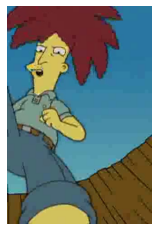

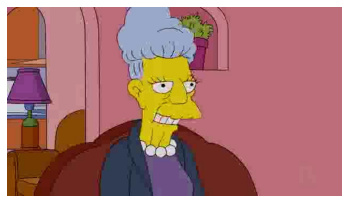

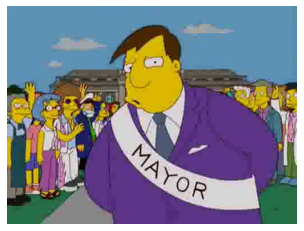

In [9]:
#Select some random images
files = []

for i in range(0, 3):
    path = train_dir#'./dataset/simpsons_dataset/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    img=mpimg.imread((files[i]))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [10]:
#Image size for regenerator
img_rows, img_cols = 150, 150
batch_size = 20

#Set up train and validation generators
train_data_dir = train_dir
validation_data_dir = validation_dir

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size,class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='categorical')

Found 15682 images belonging to 42 classes.
Found 5251 images belonging to 42 classes.


In [11]:
#Get classes names and number of them
from glob import glob
classes = [i[15:-1].upper() for i in sorted(glob('./dataset//simpsons//train//*//'))]
print("Classes: ",classes)
num_classes = len(classes)
print("Number of classes: ",num_classes)

Classes:  ['SONS//TRAIN\\ABRAHAM_GRAMPA_SIMPSON', 'SONS//TRAIN\\AGNES_SKINNER', 'SONS//TRAIN\\APU_NAHASAPEEMAPETILON', 'SONS//TRAIN\\BARNEY_GUMBLE', 'SONS//TRAIN\\BART_SIMPSON', 'SONS//TRAIN\\CARL_CARLSON', 'SONS//TRAIN\\CHARLES_MONTGOMERY_BURNS', 'SONS//TRAIN\\CHIEF_WIGGUM', 'SONS//TRAIN\\CLETUS_SPUCKLER', 'SONS//TRAIN\\COMIC_BOOK_GUY', 'SONS//TRAIN\\DISCO_STU', 'SONS//TRAIN\\EDNA_KRABAPPEL', 'SONS//TRAIN\\FAT_TONY', 'SONS//TRAIN\\GIL', 'SONS//TRAIN\\GROUNDSKEEPER_WILLIE', 'SONS//TRAIN\\HOMER_SIMPSON', 'SONS//TRAIN\\KENT_BROCKMAN', 'SONS//TRAIN\\KRUSTY_THE_CLOWN', 'SONS//TRAIN\\LENNY_LEONARD', 'SONS//TRAIN\\LIONEL_HUTZ', 'SONS//TRAIN\\LISA_SIMPSON', 'SONS//TRAIN\\MAGGIE_SIMPSON', 'SONS//TRAIN\\MARGE_SIMPSON', 'SONS//TRAIN\\MARTIN_PRINCE', 'SONS//TRAIN\\MAYOR_QUIMBY', 'SONS//TRAIN\\MILHOUSE_VAN_HOUTEN', 'SONS//TRAIN\\MISS_HOOVER', 'SONS//TRAIN\\MOE_SZYSLAK', 'SONS//TRAIN\\NED_FLANDERS', 'SONS//TRAIN\\NELSON_MUNTZ', 'SONS//TRAIN\\OTTO_MANN', 'SONS//TRAIN\\PATTY_BOUVIER', 'SONS//TRAIN\\P

In [12]:
#After many tries, what is the best layering setup,I concluded with the following model.
#Prepare our model

from keras.layers import BatchNormalization

model = Sequential()
# First CONV-ReLU Layer
model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu', input_shape = (img_rows, img_cols, 3)))
model.add(BatchNormalization())

# Second CONV-ReLU Layer
model.add(Conv2D(64, (3, 3), padding = "same", activation='relu', input_shape = (img_rows, img_cols, 3)))
model.add(BatchNormalization())

# Max Pooling with Dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 3rd set of CONV-ReLU Layers
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())

# 4th Set of CONV-ReLU Layers
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 5th Set of CONV-ReLU Layers
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())

# 6th Set of CONV-ReLU Layers
model.add(Conv2D(256, (3, 3), padding="same", activation='relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout 
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# First set of FC or Dense Layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Second set of FC or Dense Layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='sigmoid'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 128)       7

In [ ]:
#Another dynamic way of creating models through classes.
#Create classes for storing our model and its layers,so as to be reusable enough
class SimpsonsModel:
    def __init__(self,train_dir,validation_dir,layers,rows,columns):
        self.train_dir = train_dir
        self.validation_dir = validation_dir
        self.layers = list(layers)
        self.rows = rows
        self.columns = columns

class Layer:
    def __init__(self,layer_type,layer_no,filters,kernel_size,padding,activation,input_shape,max_pooling,pool_size,batch_normalization,dropout,dropout_rate,units):
        self.layer_type = layer_type
        self.layer_no = layer_no
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.padding = padding
        self.activation = activation
        self.input_shape = input_shape
        self.max_pooling = max_pooling
        self.pool_size = pool_size
        self.batch_normalization = batch_normalization
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        self.units = units

In [ ]:
#Function to prepare our model, can be decorated with future layers and custom implementation
def PrepareModel(input_model):
    model = Sequential()

    for layer in input_model.layers:
        print(str(layer.layer_no) + " " + layer.layer_type)
        if (layer.layer_type == "Conv2D"):
            if (layer.input_shape):
                model.add(Conv2D(layer.filters, layer.kernel_size, padding = layer.padding, activation=layer.activation, input_shape = layer.input_shape))
            else:
                model.add(Conv2D(layer.filters, layer.kernel_size, padding = layer.padding, activation=layer.activation))
        if (layer.layer_type == "Flatten"):
            model.add(Flatten())
            continue
        if (layer.layer_type == "Dense"):
            model.add(Dense(layer.units, activation=layer.activation))
        if (layer.batch_normalization):
            model.add(BatchNormalization())
        if (layer.max_pooling):
            model.add(MaxPooling2D(pool_size=layer.pool_size))
        if (layer.dropout):
            model.add(Dropout(layer.dropout_rate))
    return model


In [ ]:
#Instatiate our simpsons model and pass layer parameters to it
#Constructor needs layer_type,layer_no,filters,kernel_size,padding,activation,input_shape,max_pooling,pool_size,batch_normalization,dropout,dropout_rate,units

layers = []

layer1 = Layer("Conv2D",1,64,(3, 3),'same','relu',(img_rows, img_cols, 3),False,(0,0),True,False,0,0)
layer2 = Layer("Conv2D",2,64,(3, 3),'same','relu',(img_rows, img_cols, 3),True,(2, 2),True,True,0.2,0)
layer3 = Layer("Conv2D",3,128,(3, 3),'same','relu',None,False,(0,0),True,False,0,0)
layer4 = Layer("Conv2D",4,128,(3, 3),'same','relu',None,True,(2, 2),True,True,0.2,0)
layer5 = Layer("Conv2D",5,256,(3, 3),'same','relu',None,False,(0,0),True,False,0,0)
layer6 = Layer("Conv2D",6,256,(3, 3),'same','relu',None,True,(2, 2),True,True,0.2,0)
flatten = Layer("Flatten",1,0,(0, 0),'','',None,True,(2, 2),False,False,0.0,0)
dense1 = Layer("Dense",1,0,(0, 0),'','relu',None,False,(0, 0),True,True,0.5,256)
dense2 = Layer("Dense",2,0,(0, 0),'','relu',None,False,(0, 0),True,True,0.5,256)
dense3 = Layer("Dense",3,0,(0, 0),'','sigmoid',None,False,(0, 0),False,False,0.0,num_classes)

layers = [layer1,layer2,layer3,layer4,layer5,layer6,flatten,dense1,dense2,dense3]
simpsonsModel = SimpsonsModel(train_dir,validation_dir,layers,img_rows,img_cols)
model_new = PrepareModel(simpsonsModel)

In [ ]:
#Check that are new model will be the same with the initiated one.Just verify that our function and class instatiation works as expected.
model_new.summary()

In [ ]:
model = model_new

In [14]:
#Reduce LR , compile model and store callbacks so as to pass them to fit_generator
#Set up train and validation generators
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import SGD, Adam
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_delta=0.00001)
callbacks = [reduce_lr]

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

# Rescale images by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size,class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(img_rows, img_cols), batch_size=batch_size, class_mode='categorical')


Found 15682 images belonging to 42 classes.
Found 5251 images belonging to 42 classes.


In [15]:
# Train our model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=callbacks)

Epoch 1/50
100/100 [==============================] - 424s 4s/step - loss: 4.6272 - accuracy: 0.0762 - val_loss: 6.3688 - val_accuracy: 0.0850
Epoch 2/50
100/100 [==============================] - 420s 4s/step - loss: 3.4400 - accuracy: 0.1504 - val_loss: 3.2543 - val_accuracy: 0.1460
Epoch 3/50
100/100 [==============================] - 419s 4s/step - loss: 3.0161 - accuracy: 0.2184 - val_loss: 2.8561 - val_accuracy: 0.2180
Epoch 4/50
100/100 [==============================] - 417s 4s/step - loss: 2.7193 - accuracy: 0.2560 - val_loss: 2.4847 - val_accuracy: 0.2990
Epoch 5/50
100/100 [==============================] - 429s 4s/step - loss: 2.5879 - accuracy: 0.2861 - val_loss: 2.4354 - val_accuracy: 0.3200
Epoch 6/50
100/100 [==============================] - 435s 4s/step - loss: 2.4400 - accuracy: 0.3125 - val_loss: 2.5329 - val_accuracy: 0.2840
Epoch 7/50
100/100 [==============================] - 445s 4s/step - loss: 2.3405 - accuracy: 0.3561 - val_loss: 2.4613 - val_accuracy: 0.3230

In [ ]:
#The model seems to behave pretty good with these parameters. it reached almost 81% accuracy on the training data and 77% on the validation data.The loss on the training set generally is steadily decreasing and the accuracy steadily increasing.The same applies to the validation set.So, our model is not overfitting.

In [16]:
# Save model
model.save('simpsons_model.h5')

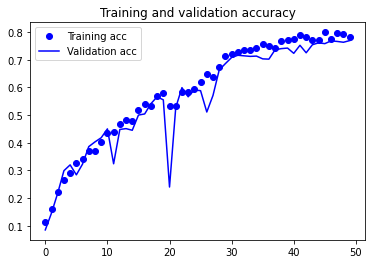

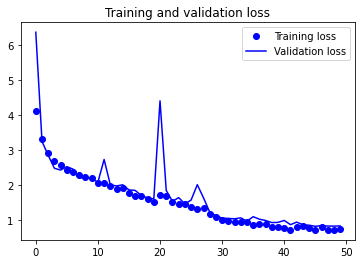

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

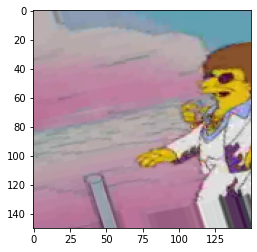

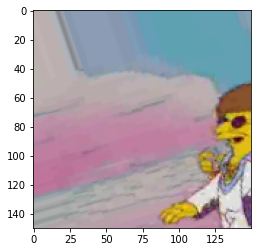

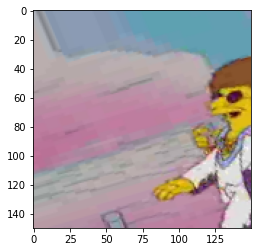

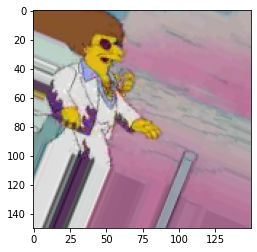

In [18]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

fnames = [os.path.join(train_data_dir, fname) for fname in os.listdir(train_data_dir)]
files_1 = list_files(fnames[10])

img_path = files_1[5]

img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [19]:
# We need to recreate our validation generator with shuffle = false
validation_generator = validation_datagen.flow_from_directory(validation_data_dir, target_size=(img_rows, img_cols),
                                                              batch_size=batch_size, class_mode='categorical', shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

Found 5251 images belonging to 42 classes.


In [23]:
#Confusion Matrix 
from sklearn.metrics import confusion_matrix

train_samples = 5251
validation_samples = 5251

Y_pred = model.predict_generator(validation_generator, validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))


Confusion Matrix
[[179   0   1 ...   0   0   0]
 [  0   1   0 ...   0   0   0]
 [  2   0 135 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0  15]]


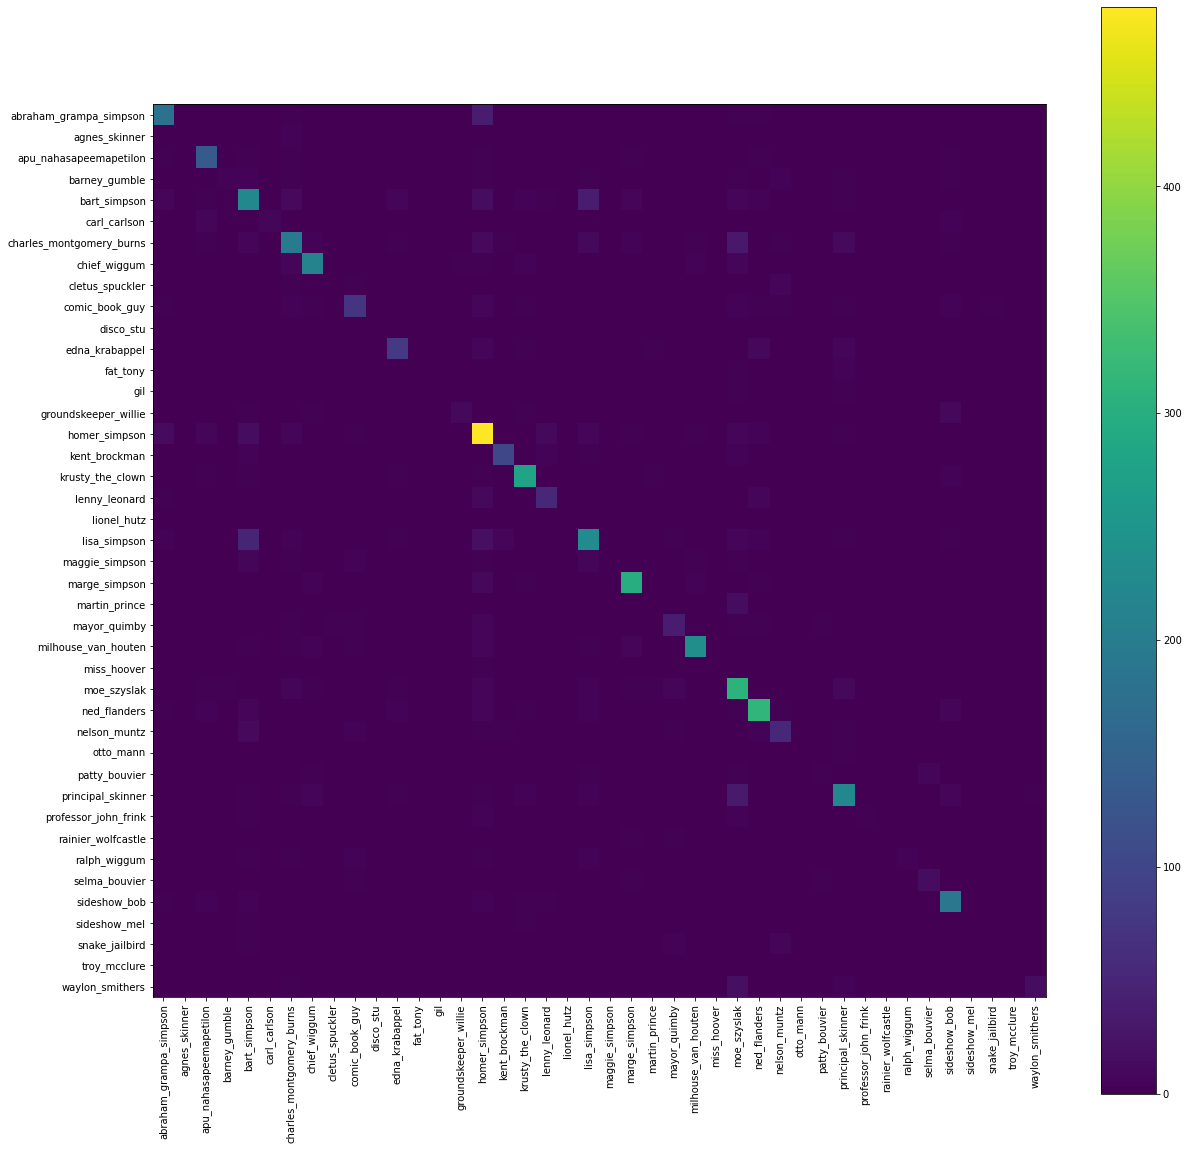

In [24]:
plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)


In [33]:
#Classification Report
from sklearn.metrics import classification_report

print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


Classification Report
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.80      0.78      0.79       229
           agnes_skinner       0.33      0.09      0.14        11
  apu_nahasapeemapetilon       0.78      0.87      0.82       156
           barney_gumble       0.56      0.19      0.28        27
            bart_simpson       0.61      0.67      0.64       336
            carl_carlson       0.64      0.36      0.46        25
charles_montgomery_burns       0.73      0.65      0.69       299
            chief_wiggum       0.85      0.87      0.86       247
         cletus_spuckler       0.00      0.00      0.00        12
          comic_book_guy       0.68      0.61      0.64       118
               disco_stu       0.00      0.00      0.00         2
          edna_krabappel       0.70      0.70      0.70       115
                fat_tony       0.00      0.00      0.00         7
                     gil       1.00      0.14      0.

# Use of pre-trained model

In [81]:
from keras.models import Sequential, Model, load_model
fully_connected_layers = [256, 256]

def build_model(base_model): 
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    
    for fc in fully_connected_layers:
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(rate=0.5)(x)

    predictions = Dense(num_classes, activation='sigmoid')(x) 
    
    model_built = Model(inputs=base_model.input, outputs=predictions)

    return model_built

In [82]:
def build_model_using_VGG16():
    # Can be decorated with different pre-trained models
    base_model = VGG16(weights='imagenet', 
                       include_top=False,
                       input_shape=(150, 150, 3))

    model = build_model(base_model)
    model.summary()
    return model

In [83]:
model = build_model_using_VGG16()

#Compile model
opt = Adam(lr=0.0001, decay=0.000001)
model.compile(opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0  

In [86]:
#Fit our pre-trained model
callbacks_list = []

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

history = model.fit_generator(train_generator, 
                                  steps_per_epoch=100, 
                                  validation_data=validation_generator, 
                                  validation_steps=100, 
                                  epochs=50, 
                                  workers=100, 
                                  shuffle=True,
                                  callbacks=callbacks_list)

Found 15682 images belonging to 42 classes.
Found 5251 images belonging to 42 classes.
Epoch 1/50
100/100 [==============================] - 133s 1s/step - loss: 2.6919 - accuracy: 0.2430 - val_loss: 2.4432 - val_accuracy: 0.4335
Epoch 2/50
100/100 [==============================] - 150s 2s/step - loss: 2.6103 - accuracy: 0.2895 - val_loss: 2.3065 - val_accuracy: 0.4465
Epoch 3/50
100/100 [==============================] - 141s 1s/step - loss: 2.4960 - accuracy: 0.3070 - val_loss: 2.2358 - val_accuracy: 0.4720
Epoch 4/50
100/100 [==============================] - 135s 1s/step - loss: 2.4499 - accuracy: 0.3305 - val_loss: 2.1138 - val_accuracy: 0.5135
Epoch 5/50
100/100 [==============================] - 137s 1s/step - loss: 2.3617 - accuracy: 0.3600 - val_loss: 2.0608 - val_accuracy: 0.5185
Epoch 6/50
100/100 [==============================] - 134s 1s/step - loss: 2.3024 - accuracy: 0.3845 - val_loss: 1.9694 - val_accuracy: 0.5555
Epoch 7/50
100/100 [==============================] - 1

In [ ]:
#In this case, our model from scratch provided a little more better results than the pre-trained one.Interesting!

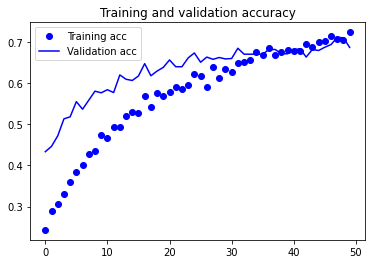

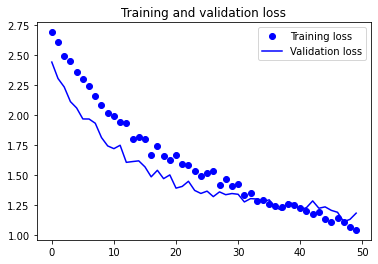

In [89]:
#Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Testing Images

In [26]:
#Function to test image from test directory and get predicted result
def TestImage(path,test_model):
    img=mpimg.imread(path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    img = image.load_img(path, target_size=(150, 150))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x.astype('float32')/255
    pred1 = np.argmax(test_model.predict(x))
    print("Predicted character:{}.".format(class_labels[pred1])) 

In [27]:
#Load model
from keras.models import load_model
model1 = load_model('./simpsons_model.h5')


Selected filename: ./dataset/simpsons/test/pic_1546.jpg


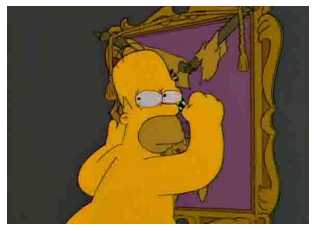

Predicted character:homer_simpson.

Selected filename: ./dataset/simpsons/test/pic_1192.jpg


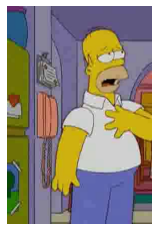

Predicted character:homer_simpson.

Selected filename: ./dataset/simpsons/test/pic_0079.jpg


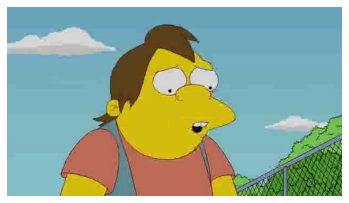

Predicted character:nelson_muntz.

Selected filename: ./dataset/simpsons/test/pic_1089.jpg


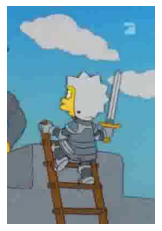

Predicted character:bart_simpson.

Selected filename: ./dataset/simpsons/test/pic_0172.jpg


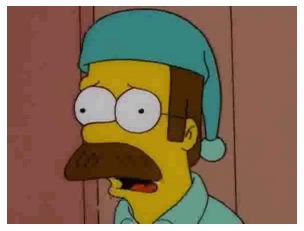

Predicted character:ned_flanders.

Selected filename: ./dataset/simpsons/test/pic_0663.jpg


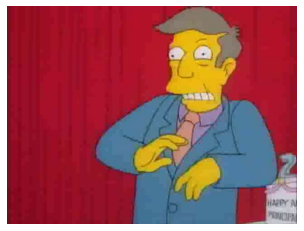

Predicted character:principal_skinner.

Selected filename: ./dataset/simpsons/test/pic_1856.jpg


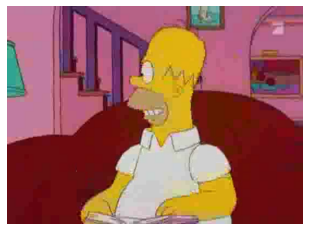

Predicted character:homer_simpson.

Selected filename: ./dataset/simpsons/test/pic_0338.jpg


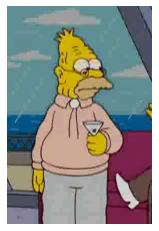

Predicted character:abraham_grampa_simpson.

Selected filename: ./dataset/simpsons/test/pic_1736.jpg


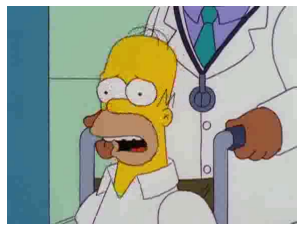

Predicted character:homer_simpson.

Selected filename: ./dataset/simpsons/test/pic_2098.jpg


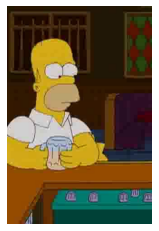

Predicted character:homer_simpson.



In [28]:
# Perform test for random images and get predicted results

path = test_dir
for i in range(0,10):
    random_filename = random.choice([
        x for x in os.listdir(test_dir)
        if os.path.isfile(os.path.join(path, x))
    ])
    random_filename = os.path.join(test_dir,random_filename)
    print("Selected filename: " + random_filename)

    TestImage(random_filename,model1)
    print("")